# Chapter 1: Computer Vision & Deep Learning - First Steps

In this introductory chapter, we learned more about *Computer Vision*, *Deep Learning*, and *how neural networks work*.

To better grasp these concepts before switching to TensorFlow, we described how to build our own simple neural network from scratch, and apply it to a classification task. In this notebook, we quickly present an overview of the code and results explained in the book.

## At the Beginning: the Neuron

[neuron.py](neuron.py) contains our implementation of a single *artificial neuron* able to process and forward information. Let's demonstrate how it works:

In [1]:
import numpy as np      # We use numpy to make vector and matrix computations easy.
from neuron import Neuron
np.random.seed(42)      # Fixing the seed for the random number generation, to get reproducable results.

First, we instantiate our neuron. Let's create a *perceptron* taking 2 input values, and using the step function for computing its *activation*. Its weights and bias values are randomly set.

In [2]:
input_size = 3
step_function = lambda y: 0 if y <= 0 else 1

perceptron = Neuron(num_inputs=input_size, activation_function=step_function)
print("Perceptron's random weights = {} , and random bias = {}".format(perceptron.W, perceptron.b))

Perceptron's random weights = [ 0.37454012  0.95071431  0.73199394] , and random bias = [ 0.59865848]


We randomly generate a random input vector of 3 value (i.e. a column-vector of (shape = `(1, 3)`), to be fed to our neuron:

In [3]:
x = np.random.rand(input_size).reshape(1, input_size)
print(x)

[[ 0.15601864  0.15599452  0.05808361]]


We can now feed our perceptron with this input and display the corresponding activation. We invite our readers to try different inputs or edit the weights.

In [4]:
perceptron.forward(x)

1

## Layering Neurons Together

In this section, we presented how neurons can be organized into layers, with the corresponding class implemented in [fully_connected_layer.py](fully_connected_layer.py). Once again, let's quickly show how this *layer* can be used to process input values, one by one or stacked together as *batches*:

In [5]:
from fully_connected_layer import FullyConnectedLayer
np.random.seed(42)      # Fixing the seed again, to get reproducable results.

We instantiate a layer of 3 neurons (so 3 output values), taking 2 input values and applying this time the ReLU (Rectified Linear Unit) function for the activations: 

In [6]:
input_size = 2
num_neurons = 3
relu_function = lambda y: np.maximum(y, 0)

layer = FullyConnectedLayer(num_inputs=input_size, layer_size=num_neurons, activation_function=relu_function)

We randomly generate 2 random input vectors:

In [7]:
x1 = np.random.uniform(-1, 1, 2).reshape(1, 2)
x1

array([[-0.63635007, -0.63319098]])

In [8]:
x2 = np.random.uniform(-1, 1, 2).reshape(1, 2)
x2

array([[-0.39151551,  0.04951286]])

Our layer can either process them separetely:

In [9]:
layer.forward(x1)

array([[ 0.29875996,  1.00368303,  0.        ]])

In [10]:
layer.forward(x2)

array([[ 1.46015109,  0.80997374,  0.        ]])

... or together:

In [11]:
x12 = np.concatenate((x1, x2))  # stack of input vectors, of shape `(2, 2)`
layer.forward(x12)

array([[ 0.29875996,  1.00368303,  0.        ],
       [ 1.46015109,  0.80997374,  0.        ]])

## Applying our Network to Classification

Using untrained perceptrons and layers on random inputs is however a bit dull. In this final section of the notebook, we cover the application of our simple model to the hand-written digit classification task (on the [MNIST dataset](http://yann.lecun.com/exdb/mnist)) presented in the book.

[simple_network.py](simple_network.py) wraps everything together into a modular *neural network* model with the optimization process described along the chapter.

### Setting Up the Task

Before implementing a solution, let's prepare the data, loading the MNIST data for training and testing methods. For simplicity, we will use the Python module [`mnist`](https://github.com/datapythonista/mnist) developed by [Marc Garcia](https://github.com/datapythonista), and already installed in this chapter's directory (see [`./mnist/`](mnist/__init__.py)).

In [33]:
%matplotlib inline
import matplotlib    # we also import matplotlib, to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

The `python-mnist` module makes it simple to load the training and testing data (images and their labels):

In [34]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

How big are our training and testing datasets?

In [35]:
X_train.shape

(60000, 28, 28)

In [36]:
X_test.shape

(10000, 28, 28)

i.e. we have 60,000 training samples and 10,000 testing one, with each sample an image of 28 by 28 pixels.

We can have a look at the data, for instance using `matplotlib`:

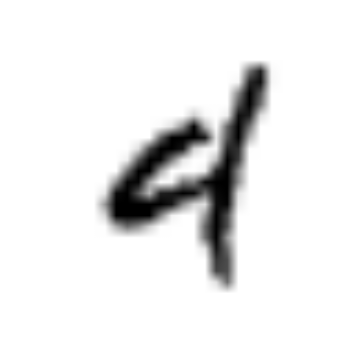

In [37]:
img_idx = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [38]:
y_train[img_idx]

4

... Our images match their label, which is good news!

However, as our network only accepts column vectors, we need to "flatten" the images into 1D vector, i.e. vectors of shape `(1, 784)` (since 28 * 28 = 784):

In [39]:
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)

Also, let's have a look at our pixel values:

In [40]:
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

Pixel values between 0 and 255


Those are normal interger values for images with 8 bits per channel (`uint8`)... These values may be however too big for some of our operations. For instance, given a too big input value, our sigmoid may return a `nan` value (because of the exponential function it uses, which may "overflow" with a large input value).

It is thus customary to *normalize* the input data, i.e. to scale the values between 0 and 1 (or -1 and 1):

In [41]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


Finally, to compute the loss, we need to "one-hot" the labels, e.g. converting the label `4` into `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`:

In [42]:
y_train = np.eye(num_classes)[y_train]

### Implementing the Network

As mentioned before, all the NN logic explained in the book is implemented in [simple_network.py](simple_network.py).
Let's use it to instantiate a network with 2 hidden layers, taking a flattened image as input and returning a 10-value vector representing its belief the image belongs to each of the class (the highter the value,the stronger the belief): 

In [43]:
from simple_network import SimpleNetwork

In [44]:
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], num_outputs=num_classes, hidden_layers_sizes=[64, 32])

We can now check how our network performs (computing its *loss* over the training set, and its *accuracy* over the test set):

In [45]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 4.436700 | val accuracy = 12.19%


... and the answer is: it performs really poorly... But as we know from the book, this is to be expected: we have yet to train our network

### Teaching our Network to Classify

This is where things finally get interesting. As the whole training procedure is already explained and implemented (c.f. [simple_network.py](simple_network.py)), we simply have to launch it:

In [46]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, batch_size=30, num_epochs=500)
# note: Reduce the batch size and/or number of epochs if your computer can't handle the computations / takes too long.
#       Remember, numpy also uses the CPU, not the GPU as modern Deep Learning libraries do, hence the lack of performance here.

Epoch    0: training loss = 1.096978 | val accuracy = 19.10%
Epoch    1: training loss = 0.886127 | val accuracy = 32.17%
Epoch    2: training loss = 0.785361 | val accuracy = 44.06%
Epoch    3: training loss = 0.695873 | val accuracy = 50.68%
Epoch    4: training loss = 0.630815 | val accuracy = 56.25%
Epoch    5: training loss = 0.576848 | val accuracy = 61.30%
Epoch    6: training loss = 0.519389 | val accuracy = 67.69%
Epoch    7: training loss = 0.465288 | val accuracy = 71.35%
Epoch    8: training loss = 0.426172 | val accuracy = 74.30%
Epoch    9: training loss = 0.396564 | val accuracy = 76.31%
Epoch   10: training loss = 0.372741 | val accuracy = 77.75%
Epoch   11: training loss = 0.352826 | val accuracy = 78.98%
Epoch   12: training loss = 0.335768 | val accuracy = 80.12%
Epoch   13: training loss = 0.320914 | val accuracy = 81.04%
Epoch   14: training loss = 0.307823 | val accuracy = 81.87%
Epoch   15: training loss = 0.296183 | val accuracy = 82.44%
Epoch   16: training los

Almost **95%** of accuracy! This is much better.

Congratulations for implementing and training your first neural network classifier!

Finally, we can plot the evolution of the loss and accuracy during the training, to better visualize the evolution:

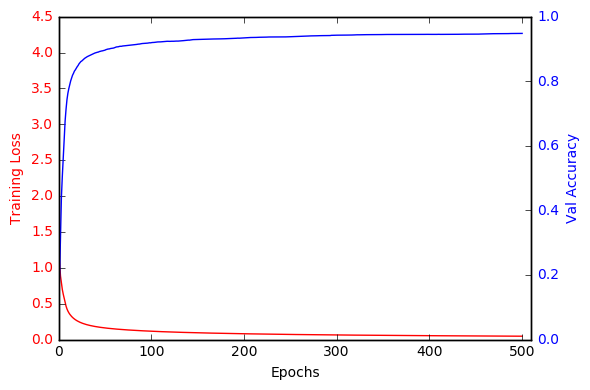

In [47]:
losses, accuracies = [loss_untrained] + losses, [accuracy_untrained] + accuracies
fig, ax_loss = plt.subplots()

color = 'red'
ax_loss.set_xlim([0, 510])
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Training Loss', color=color)
ax_loss.plot(losses, color=color)
ax_loss.tick_params(axis='y', labelcolor=color)

ax_acc = ax_loss.twinx()  # instantiate a second axes that shares the same x-axis
color = 'blue'
ax_acc.set_xlim([0, 510])
ax_acc.set_ylim([0, 1])
ax_acc.set_ylabel('Val Accuracy', color=color)
ax_acc.plot(accuracies, color=color)
ax_acc.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As we can see, our network *converged* quite fast, though the accuracy slowly kept increasing. It looks even like the accuracy could still go up a bit with some further training iterations... Feel free to try. 

In any case,this is it for chapter 1!